# Test

1. Treinar um modelo de rede neural nesse conjunto de dados disponível no material da disciplina.
a. O conjunto de dados possui uma grande variedade de celebridades.
2. Uma vez treinado o modelo, vocês devem criar um banco de dados com as imagens das
celebridades com o output do vetor descritor do seu modelo.
3. Após o treinamento da rede neural, vocês devem incluir a foto de 1 integrante do grupo no banco
de dados.
4. Uma vez concluídas as etapas (1), (2) e (3), vocês devem tirar a pessoa do item (3) usando
máscara facial e fazer o reconhecimento facial dela.

## Setup

In [1]:
from keras.models import load_model
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
import numpy as np
from PIL import Image, ImageOps
import os
import sys
import cv2
from google.colab.patches import cv2_imshow
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
from os.path import join
import sqlite3 as sql
from zipfile import ZipFile
from keras.applications.vgg16 import VGG16
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Funcs

In [3]:
base_path = '/content/drive/MyDrive/PDI_EduardoSavian_PabloMarques_VitorCoelho_YuriRodrigues/Colab Notebooks/'

#### Load image

In [4]:
def load_image(image):
  nparr = np.frombuffer(image, np.uint8)
  img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (224, 244))

  return img

### Plot

In [5]:
def plot_img1(name: str, image: np.ndarray, position: int):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.subplot(position),plt.imshow(image, cmap = 'gray')
    plt.title(name), plt.xticks([]), plt.yticks([])

In [6]:
def plot_img2(img1: np.ndarray, img2: np.ndarray, name1="Image 1", name2="Image 2"):
    plt.figure(figsize=(6, 6))

    plot_img1(name1, img1, 121)
    plot_img1(name2, img2, 122)

    plt.tight_layout()
    plt.show()

### Predict

In [7]:
def predict(object_image: image):
  # convert image into 3d array and add additional dimension for model input
  # return feature vector
  image_array = np.expand_dims(image.img_to_array(object_image), axis = 0)

  return model.predict(image_array)

In [8]:
def calculate_similarity(img1, img2):
  img1_vector = predict(img1)
  img2_vector = predict(img2)
  similarity_score = cosine_similarity(img1_vector, img2_vector)

  return similarity_score.reshape(1,)

In [9]:
def similarity(img1, img2):
  img1 = cv2.resize(img1, (224, 224))
  img2 = cv2.resize(img2, (224, 224))

  similarity_score = calculate_similarity(img1, img2)
  print("\nSimilarity: " + str(similarity_score[0] * 100) + "%")
  plot_img2(img1, img2, 'Image 1', 'Image 2')

## SQL

#### Func import

In [10]:
def drop_and_create(db_path):
  #Conectando no banco de dados
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    table_name = 'people'

    # Executar a consulta SQL
    cursor.execute(f"DROP TABLE IF EXISTS {table_name}")

    # Commit para aplicar as alterações ao banco de dados
    connection.commit()
    consulta_sql = f'''
          CREATE TABLE IF NOT EXISTS {table_name}(
              id INTEGER PRIMARY KEY,
              person_name TEXT,
              image_name TEXT,
              image BLOB
              descriptor_vector BLOB
          )
    '''
    cursor.execute(consulta_sql)

    connection.commit()

In [11]:
def read_image_from_zip_insert_sql(zip_path,img_size,img_limit,connection):
  cursor = connection.cursor()

  with ZipFile(zip_path, 'r') as zip_file:
    for item in zip_file.infolist():
        # Verifica se o item é um diretório (pasta)
        if item.is_dir():
          # Obtém o nome do diretório
          folder_name = item.filename

          listOfItens = zip_file.infolist()[:img_limit] if img_limit > 0 else zip_file.infolist()

          # Itera sobre todos os itens dentro do diretório
          for sub_item in listOfItens:
            # Verifica se o item pertence ao diretório atual
            if sub_item.filename.startswith(folder_name) and not sub_item.is_dir():
              # Lê o conteúdo do arquivo zip
              img = zip_file.read(sub_item.filename)

              image_name = os.path.basename(sub_item.filename)

              if folder_name.split('/')[1] != '':
                person_name = folder_name.split('/')[1]
                consultaSQL=f"""INSERT INTO people(person_name,image_name, image) VALUES ('{person_name}', '{image_name}', ?)"""
                cursor.execute(consultaSQL,(sql.Binary(img),))

  connection.commit()

In [12]:
def insert_zip(ds_path, db_path):
  with sql.connect(db_path) as connection:
    read_image_from_zip_insert_sql(ds_path,224,0,connection)

In [13]:
def calculate_all_descriptor_vectors(db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"SELECT image FROM people"

    cursor.execute(consulta_sql)
    results = cursor.fetchall()

    for images_b in results:
        img = load_image(images_b[0])
        pred = predict(img)
        query = f"UPDATE people SET descriptor_vector={pred} Where={images_b}"

### Selects

#### Person

In [14]:
def select_person_name_prefix(name_prefix, db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"SELECT person_name FROM people WHERE person_name LIKE '{name_prefix}%'"

    cursor.execute(consulta_sql)
    results = cursor.fetchall()

    for row in results:
        print(row[0])

In [15]:
def select_image_name_prefix(name_prefix, db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"SELECT person_name FROM people WHERE person_name LIKE '{name_prefix}%'"

    cursor.execute(consulta_sql)
    results = cursor.fetchall()

    return results

#### Image name

In [16]:
def select_image_name(name, db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"select image from people where image_name='{name}'"

    result = cursor.execute(consulta_sql).fetchone()

    if result is not None:
        image_b = result[0]
        nparr = np.frombuffer(image_b, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 244))

        return img
    else:
        print("No data found for the query.")
        return None

In [17]:
def select_image_name_prefix(name_prefix, db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"SELECT image_name FROM people WHERE person_name LIKE '{name_prefix}%'"

    cursor.execute(consulta_sql)
    results = cursor.fetchall()

    for row in results:
        print(row[0])

In [18]:
def select_image_name(name, db_path):
  with sql.connect(db_path) as connection:
    cursor = connection.cursor()
    consulta_sql = f"select image from people where image_name='{name}'"

    result = cursor.execute(consulta_sql).fetchone()

    if result is not None:
        image_b = result[0]
        nparr = np.frombuffer(image_b, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 244))

        return img
    else:
        print("No data found for the query.")
        return None

## Test

#### Load Model

In [19]:
models_path = join(base_path, 'models')

In [20]:
model_path = join(models_path, 'model.h5')

In [21]:
model = load_model(model_path)
classifier = model
# classifier = Model(model.inputs, model.get_layer('FeatureVector').output)

#### Import images

In [22]:
dt_path = join(base_path, 'data')
db_path = join(dt_path, 'dataset.db')
ds_o_path = join(dt_path, 'data.zip')
ds_t_path = join(dt_path, 'data_test.zip')

In [23]:
drop_and_create(db_path)

In [56]:
insert_zip(ds_o_path, db_path)

In [24]:
insert_zip(ds_t_path, db_path)

In [71]:
select_person_name_prefix('test', db_path)

Teste_Teste
Teste_Teste
Teste_Teste
Teste_Teste
Teste_Teste
Teste_Teste


In [72]:
select_image_name_prefix('Teste_Teste', db_path)

img_test_3.jpg
img_test_3_mask.jpg
img_test_5.jpg
img_test_5_mask.jpg
img_test_6.jpg
img_test_6_mask.jpg


In [26]:
img1 = select_image_name('img_test_3.jpg', db_path)
img2 = select_image_name('img_test_3_mask.jpg', db_path)
img3 = select_image_name('img_test_5.jpg', db_path)
img4 = select_image_name('img_test_5_mask.jpg', db_path)
img5 = select_image_name('img_test_6.jpg', db_path)
img6 = select_image_name('img_test_6_mask.jpg', db_path)

#### Similarity

In [ ]:
similarity(img1, img2)

In [ ]:
similarity(img1, img3)

In [ ]:
similarity(img1, img4)

In [ ]:
similarity(img1, img5)

In [ ]:
similarity(img1, img6)

In [ ]:
#calculate_all_descriptor_vectors(db_path)

In [28]:
def get_max_similarity(img_ref,name):
  imgSimilarity = {}
  cvImgRef = cv2.resize(img_ref, (224, 224))

  with sql.connect(db_path) as connection:
    connection.row_factory = sql.Row
    cursor = connection.cursor()
    consulta_sql = f"SELECT image_name,image FROM people"

    cursor.execute(consulta_sql)
    results = cursor.fetchall()
    for row in results:
      #print(row[0])

      if row['image_name'] == name:
        continue
      nparr = np.frombuffer(row['image'], np.uint8)
      imgRow = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

      imgRow = cv2.resize(imgRow, (224, 224))
      imgSimilarity[row['image_name']] = calculate_similarity(cvImgRef,imgRow)

  return max(imgSimilarity, key=imgSimilarity.get)

q = get_max_similarity(img1,'img_test_3.jpg')
print(q)

1/1 [==============================] - 1s 598ms/step
img_test_3_mask.jpg


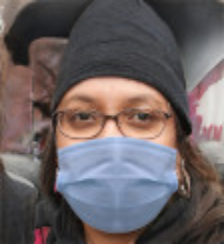

In [30]:
cv2_imshow(select_image_name('img_test_3_mask.jpg', db_path))